**MDPs And Basic RL Algoirhtms!** 

In this first notebook, we will look at Markov Decision Processes and some basic RL algorithms that can solve them! 
Some cells still need to be finished, leaving them as a challenge for you to solve! Some of these challenges are difficult, so don't worry if you get stuck. Answers are also available on a completed version of this notebook in the answers folder! Good luck! 

In [33]:
#Our imports
from Environments.maze import maze_game
import numpy as np
import scipy.signal
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
from gymnasium import spaces

**The MDP**

A sensible first step when working on an RL problem, is taking a look at the Markov Decision Process (MDP) we are trying to solve (you can see the code for the env in Environments/maze.py). The observertion and action spaces describe the ins and outs of the MDP. An environment will expect inputs (actions) in the same format as its action_space. A policy will need to conform to these spaces, outputing actions that match the environments action_space, and accpet inputs in the form of the observation_space.

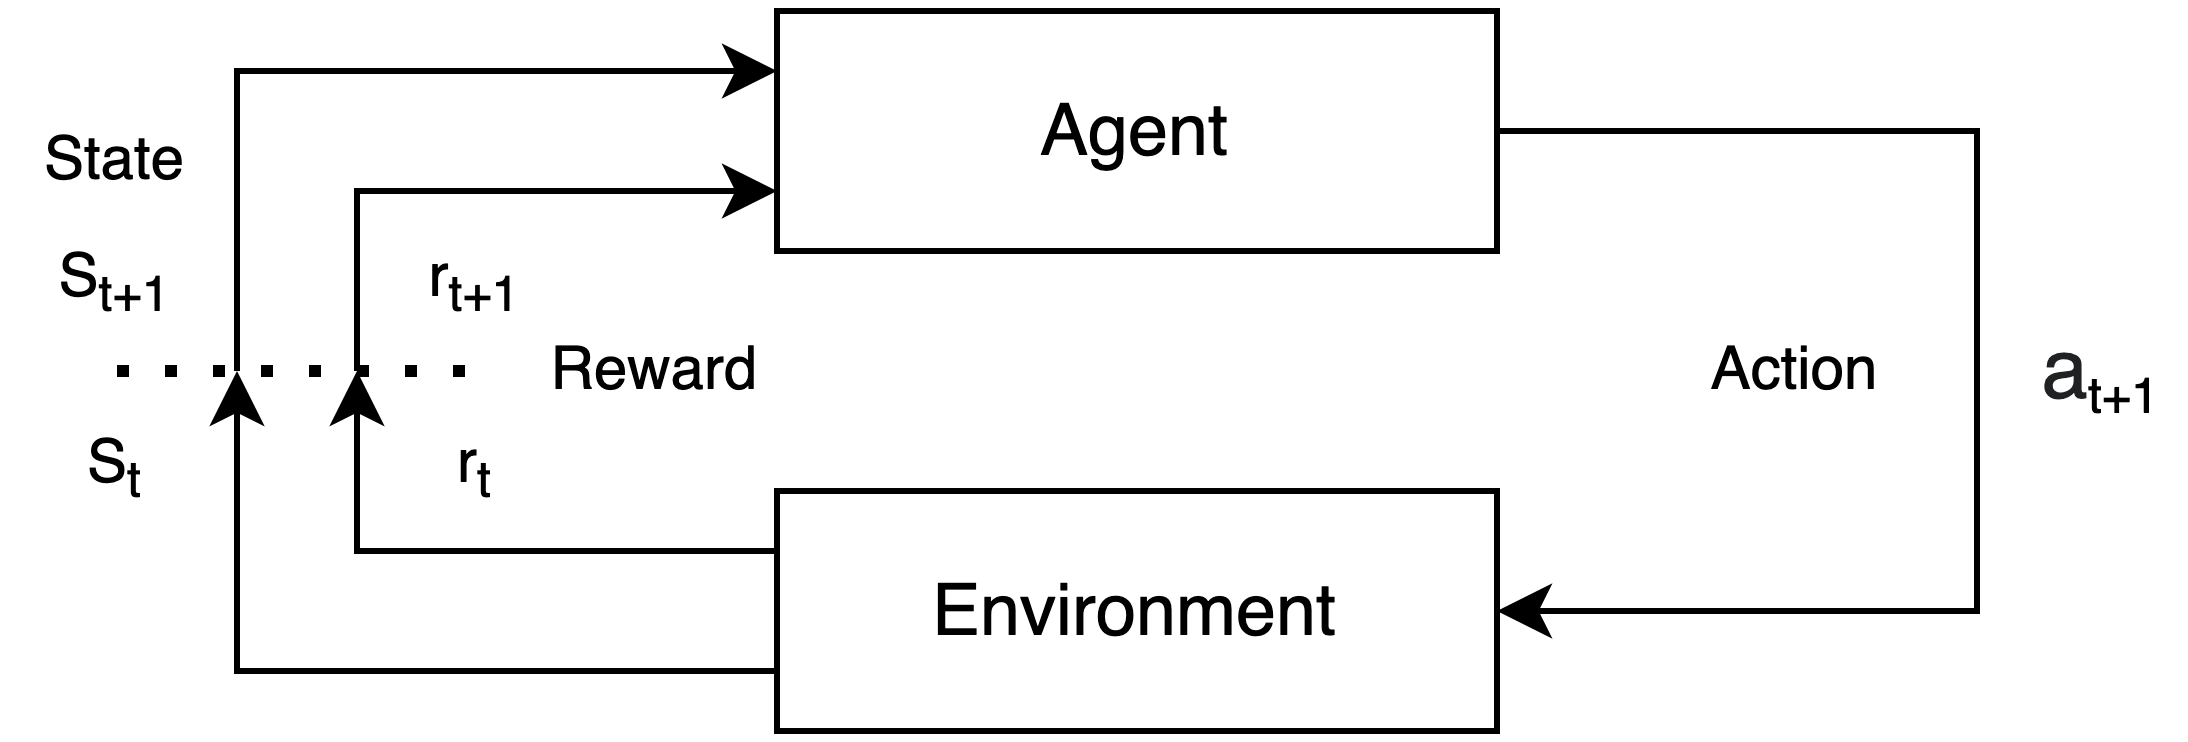

In [2]:
#Create an instance of the MDP we are going to solve
env = maze_game(difficulty='easy')
#Reset is a function MDPs use to reset the environment between episodes
env.reset()
print('Observation Space: ',  env.observation_space)
print('Action Space: ', env.action_space)
print(env.maze)

Observation Space:  Discrete(25)
Action Space:  Discrete(4)
[['A' 'X' ' ' ' ' ' ']
 [' ' 'X' ' ' 'X' ' ']
 [' ' ' ' ' ' 'X' 'X']
 [' ' 'X' ' ' ' ' ' ']
 [' ' 'X' ' ' 'X' 'G']]


The agent starts an episode at 'A', and needs to navigate to 'G'. When the agent arrives at 'G', the episode ends, and a possitive reward is given. The agent cannot pass through 'X'. 

Lets take a closer look at the spaces. The action space lets the agent move in 1 of the 4 cardinal directions, given by an integer. The 'Discrete' action space describes this. Discrete(4) allows interger actions in [0,4).

In [3]:
#.sample() can be used to see the action format expected by an environment
env.action_space.sample()

1

The observation space is Discrete(25) (integer actions in [0,25)). This is gives the policy the index of the grid square the agent is currently standing on. 

In [4]:
env.observation_space.sample()

20

**The Algorithms**

Now that we have an understanding of the MDP, we can implement some learning algorithms. Lets start with a value-based method 'Q-Learning'. We will stick to a tabular form for now, as it is easier to understand.   

Lets recall some of Q-Learning's notation:

$Q(s,a)$ is the value of taking action $a$ at state $s$ (the value of the state-action pair). If $Q(s,a)$ is optimal, the value is the discounted reward that is accumliated between taking $a$ at $s$ and the end of the episode. We use the idea of discounted reward to weight the difference between short term and long term rewards. More on this later. In tabular Q-Learning $Q(s,a)$ is represented by a table of length equal to the number of states, and width equal to the number of actions. In the maze problem, this would be a 25 by 4 matrix.

For now, lets condsider how actions are selected in tabular Q-Learning. We know that when we are at any $s$ in the maze, we have 4 actions availble to us. The optimal action will be the action that moves the agent closer to the goal, moving closer to goal moves the agent closer to reward, so the value of that action at $s$ will be greater than the other actions at $s$. So, to select an action, we take the argmax of $Q(s,a)$ at $s$; this is a 'greedy policy' (it always takes the best action). 

Typically, Q-Learning extends this basic 'greedy' policy by adding in random action selection. $\frac{\epsilon}{1}$ of the actions selected by an $\epsilon$-greedy policy will be random. Random action selection lets the agent explore paths it wouldn't choose otherwise. In code, we can write an $\epsilon$-greeedy policy as:

In [6]:
def epsilon_greedy_policy(state, q_table, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(4)
    return np.argmax(q_table[state])

So, we know how tabular Q-Learning selects actions using its Q-Table, but how does it optimise this Q-Table?

As well as being value-based, Q-Learning is also a temporal difference (TD) learner. TD is the value delta between 2 timesteps. 

If an agent takes $a$ in $s$ its state changes to $s'$. TD learning links the value of a state to the value of the next states it can transition to. So, some $Q(s,a)$'s value is linked to the future value $Q(s',a)$, this value is proportional of the discount factor $\gamma$. So to calculate the TD error, we talk about the difference between $Q(s,a)$ and discounted optimal value from $Q(s',a)$:  $\gamma \text{max}_{a}Q(s',a)$.

The TD error is only half of $Q(s,a)$ value, as we also need to consider the reward that is obtained by taking $a$ in $s$. Adding this in, we get the full update equation: 

$Q(s,a) \xleftarrow{} Q(s,a) + \alpha(r + \gamma \text{max}_{a}Q(s',a) - Q(s,a))$

The learning rate $\alpha$ is used here to limit the update size, RL updates are stochastic, so we need to take small steps to the solution (this is similar to supervised learning and is done for the same reason). 

To use this update equation, we conduct training episodes on the environment. An episode is a loop of action selection (from the policy), taking the action (in the environment), and then updating the q_table with state tranistion data.

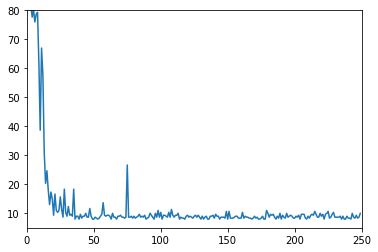

In [19]:
#Holding the Q Learning solver in a class for resuabilitiy 
class QLearningSolver():

    def __init__(self, env, policy):
        #We randomly initialise the q_table so np.argmax(q_table[state]) can resolve, it 
        #also tends to solve faster than other initialisations.
        self.q_table = np.random.random((env.observation_space.n, env.action_space.n)) 
        #Learning Parameters
        self.lr = .1
        self.gamma = .98
        self.env = env
        self.epsilon = .1
        #Pass in the policy for action selection
        self.policy = policy

    def solve(self, num_episodes=500):
        steps = []
        for episodes in range(num_episodes):
            #Reset at the start of each episode. Reset gives us the inital environment state.
            state = maze_env.reset()['state']
            done = False
            while not done:
                #get an action from the policy
                action = self.policy(state, self.q_table, self.epsilon)
                #apply the action in the environment and get the update state from the env
                new_state, reward, done, _, _ = maze_env.step(action)
                #Q Learning update 
                self.q_table[state, action] += self.lr * (reward + self.gamma * np.max(self.q_table[new_state['state'], :]) - self.q_table[state, action])
                #Update the internal state
                state = new_state['state']
            steps.append(self.env.steps)
        return steps

#One result is meaningless. We need to repeat an experiment multiple times inorder to make conclusions.
num_trails = 3
num_episodes = 250
trails = []
for i in range(num_trails):
    #Crete the env, and run a trail
    maze_env = maze_game('easy')
    q_solver = QLearningSolver(maze_env, epsilon_greedy_policy)
    trails.append(q_solver.solve(num_episodes))

plt.axis([0, num_episodes, 5, 80])
plt.plot(np.array(trails).mean(axis=0))

Hopefully you can see that Q-Learning could solve the maze problem! You should also notice that there is a fair bit of noise around the optimal step count (the shortest route through this maze is 8 steps). The noise is caused by the $\epsilon$-greedy policy.

**Challenge 1:**

After training, we need to evaluate the performance of a policy. This is done by running episodes on the target environment with all methods of exploration disabled. Modeify the code below to run an evaluation on the maze env with the Q-Learning solver. (Notice that we don't run more that one evaluation episode here. Why?)

In [32]:
step_counter = 0
state = q_solver.env.reset()
done = False
while not done:
    #get an action from the policy
    action = q_solver.policy(state['state'], q_solver.q_table, q_solver.epsilon)
    #apply the action in the environment and get the update state from the env
    state, reward, done, _, _ = maze_env.step(action)
    step_counter += 1
print('Goal reached after ' + str(step_counter) + ' steps.')

Goal reached after 8 steps.


Now we are going to take a closer look at how Q-Learning is solving the Maze Problem. 

Recall that $V(s)$ is the value of a state. The value of a state is the average expected value from taking an action in $s$. By taking $V(s)$ at each state in 

[['A' 'X' ' ' ' ' ' ']
 [' ' 'X' ' ' 'X' ' ']
 [' ' ' ' ' ' 'X' 'X']
 [' ' 'X' ' ' ' ' ' ']
 [' ' 'X' ' ' 'X' 'G']]


<AxesSubplot:>

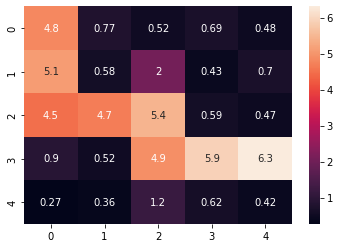

In [9]:
q_solver = QLearningSolver(maze_env, epsilon_greedy_policy)
q_solver.gamma = 0.98
q_solver.solve(num_episodes)
#Take the average value of each action at each state. 
state_values = np.mean(q_solver.q_table, axis=1)
state_values = state_values.reshape((int(np.sqrt(state_values.shape[0])),int(np.sqrt(state_values.shape[0]))))
print(env.maze)
sns.heatmap(state_values, annot=True)

At this stage, I'd encoruage playing about with the hyperparameters of Q-Learning. See what happens when you change the valeus of $\gamma$ and $\epsilon$. 

In [34]:
class one_hot_maze(maze_game):

    def __init__(self, difficulty):
        super().__init__(difficulty)
        #This wrapper updates the observation space. It is now best discribed a multibinary.
        self.observation_space = spaces.MultiBinary(self.maze.shape[0]**2)

    def step(self, action):
        state, reward, done, _, _ = super().step(action)
        state_onehot = np.zeros(self.observation_space.n)
        state_onehot[state['state']] = 1
        return {'state': state_onehot}, reward, done, None, None
    
    def reset(self):
        state = super().reset()
        state_onehot = np.zeros(self.observation_space.n)
        state_onehot[state['state']] = 1
        return {'state': state_onehot}

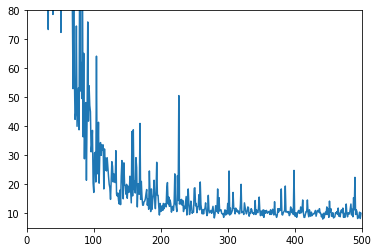

In [165]:
def softmax_policy(state, W):
    logits = np.dot(state['state'], W)
    softmax = np.exp(logits) / sum(np.exp(logits))
    action = np.random.choice(4, p=softmax)
    return action, softmax

class PolicyGradientSolver():

    def __init__(self, env, policy):
        self.W = np.random.random((env.observation_space.n, env.action_space.n)) 
        self.lr = .01
        self.gamma = .97
        self.policy = policy
        self.env = env

    def solve(self, num_episodes=500):
        steps = []
        for episodes in range(num_episodes):
            state = self.env.reset()
            rewards = []
            states = [state['state']]
            actions = []
            derivatives = []
            probs_ = []
            done = False
            while not done:
                action, probs = self.policy(state, self.W)
                probs_.append(probs[action])
                probs = np.expand_dims(probs, 1)
                jacobian = np.diagflat(probs) - np.dot(probs, probs.T)
                derivatives.append(jacobian[action])            
                actions.append(action)
                new_state, reward, done, _, _ = self.env.step(action)
                states.append(new_state['state'])
                rewards.append(reward)
                state = new_state
            steps.append(self.env.steps)
            states = np.array(states); actions = np.array(actions); derivatives = np.array(derivatives); probs_ = np.array(probs_)
            gain = scipy.signal.lfilter([1], [1, float(-self.gamma)], np.array(rewards[::-1]), axis=0)[::-1]
            #We gather the update to take an average of the loss, this massively reduces variance in the update
            update = np.zeros((derivatives.shape[0], env.observation_space.n, 4))
            update[:,np.argmax(states[:-1],axis=1),:] = derivatives * np.log(probs_.reshape(-1,1)) * gain.reshape(-1,1) 
            self.W -= self.lr * update.mean(axis=0) 
        return steps

num_trails = 5
num_episodes = 500
trails = []
for i in range(num_trails):
    maze_env = one_hot_maze('easy')
    pq_solver = PolicyGradientSolver(maze_env, softmax_policy)
    trails.append(pq_solver.solve(num_episodes))

plt.axis([0, num_episodes, 5, 80])
plt.plot(np.array(trails).mean(axis=0))

In [53]:
derivatives[i]

NameError: name 'derivatives' is not defined

[['A' 'X' ' ' ' ' ' ']
 [' ' 'X' ' ' 'X' ' ']
 [' ' ' ' ' ' 'X' 'X']
 [' ' 'X' ' ' ' ' ' ']
 [' ' 'X' ' ' 'X' 'G']]


C:\Users\Adam\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

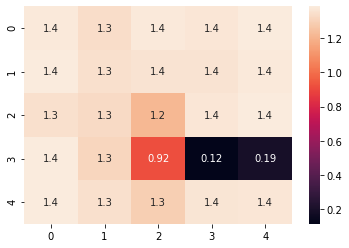

In [11]:
entropy = []
for i in range(pq_solver.env.observation_space.n):
    state = {'state': np.zeros(pq_solver.env.observation_space.n)}
    state['state'][i] = 1
    action, softmax = pq_solver.policy(state, pq_solver.W)
    entropy.append(scipy.stats.entropy(softmax))
entropy = np.array(entropy).reshape(int(np.sqrt(pq_solver.env.observation_space.n)),int(np.sqrt(pq_solver.env.observation_space.n)))
print(env.maze)
sns.heatmap(entropy, annot=True)

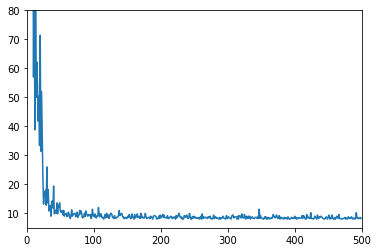

In [166]:
class PolicyGradientActorCriticSolver():

    def __init__(self, env, policy):
        self.W = np.random.random((env.observation_space.n, env.action_space.n)) 
        self.V = np.random.random((env.observation_space.n, 1)) 
        self.lr = .1
        self.gamma = .95
        self.policy = policy
        self.env = env
        self.value_lr = .1
        self.value_lambda = 0.99

    def solve(self, num_episodes=500):
        steps = []
        for episodes in range(num_episodes):
            state = self.env.reset()
            rewards = []
            states = [state['state']]
            actions = []
            derivatives = []
            probs_ = []
            done = False
            while not done:
                action, probs = self.policy(state, self.W)
                probs_.append(probs[action])
                probs = np.expand_dims(probs, 1)
                jacobian = np.diagflat(probs) - np.dot(probs, probs.T)
                derivatives.append(jacobian[action])
                actions.append(action)
                new_state, reward, done, _, _ = self.env.step(action)
                states.append(new_state['state'])
                rewards.append(reward)
                state = new_state
            steps.append(self.env.steps)
            states = np.array(states); actions = np.array(actions); derivatives = np.array(derivatives); probs_ = np.array(probs_)
            gain = scipy.signal.lfilter([1], [1, float(-self.gamma)], np.array(rewards[::-1]), axis=0)[::-1]
            update = np.zeros((derivatives.shape[0], env.observation_space.n, 4))
            update[:,np.argmax(states[:-1],axis=1),:] = derivatives * np.log(probs_.reshape(-1,1)) * (gain.reshape(-1,1) - np.dot(states[:-1], self.V))
            self.W -= self.lr * update.mean(axis=0) 
            
            #Simple gradient decent that takes advantage of the fact our state is one-hot
            update = np.zeros((states.shape[0]-1, env.observation_space.n, 1))
            update[:,np.argmax(states[:-1],axis=1),:] = (gain.reshape(-1,1) - np.dot(states[:-1], self.V))
            self.W -= self.value_lr * update.mean(axis=0) 
            self.value_lr *= self.value_lambda
            
        return steps

num_trails = 5
num_episodes = 500
trails = []
for i in range(num_trails):
    maze_env = one_hot_maze('easy')
    ac_solver = PolicyGradientActorCriticSolver(maze_env, softmax_policy)
    trails.append(ac_solver.solve(num_episodes))

plt.axis([0, num_episodes, 5, 80])
plt.plot(np.array(trails).mean(axis=0))

[['A' 'X' ' ' ' ' ' ']
 [' ' 'X' ' ' 'X' ' ']
 [' ' ' ' ' ' 'X' 'X']
 [' ' 'X' ' ' ' ' ' ']
 [' ' 'X' ' ' 'X' 'G']]


C:\Users\Adam\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

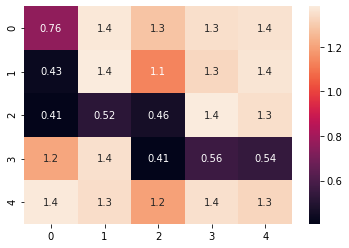

In [20]:
entropy = []
for i in range(ac_solver.env.observation_space.n):
    state = {'state': np.zeros(ac_solver.env.observation_space.n)}
    state['state'][i] = 1
    action, softmax = ac_solver.policy(state, ac_solver.W)
    entropy.append(scipy.stats.entropy(softmax))
entropy = np.array(entropy).reshape(int(np.sqrt(ac_solver.env.observation_space.n)),int(np.sqrt(ac_solver.env.observation_space.n)))
print(env.maze)
sns.heatmap(entropy, annot=True)

[['A' 'X' ' ' ' ' ' ']
 [' ' 'X' ' ' 'X' ' ']
 [' ' ' ' ' ' 'X' 'X']
 [' ' 'X' ' ' ' ' ' ']
 [' ' 'X' ' ' 'X' 'G']]


C:\Users\Adam\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

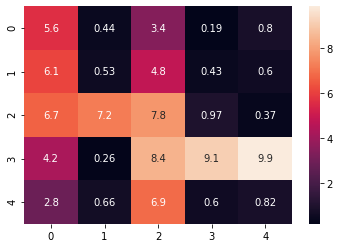

In [21]:
values = []
for i in range(ac_solver.env.observation_space.n):
    state = np.zeros(ac_solver.env.observation_space.n)
    state[i] = 1
    values.append(np.dot(state, ac_solver.V)[0])
values = np.array(values).reshape(int(np.sqrt(ac_solver.env.observation_space.n)),int(np.sqrt(ac_solver.env.observation_space.n)))
print(env.maze)
sns.heatmap(values, annot=True)

In [14]:
class one_hot_maze_action_mask(one_hot_maze):
    def step(self, action):
        state, reward, done, _, _ = super().step(action)
        #state = {'state': state}
        state['action_mask'] = self.get_action_mask()
        return state, reward, done, None, None
    
    def reset(self):
        state = super().reset()
        #state = {'state': state}
        state['action_mask'] = self.get_action_mask()
        return state
    
    def get_action_mask(self):
        action_mask = np.zeros(4)
        if self.y != 0:
            if self.maze[self.x, self.y-1] != 'X':
                action_mask[0] = 1
        if self.x != self.maze.shape[0]-1:
            if self.maze[self.x+1, self.y] != 'X':
                action_mask[1] = 1
        if self.y != self.maze.shape[1]-1:
            if self.maze[self.x, self.y+1] != 'X':
                action_mask[2] = 1
        if self.x != 0:
            if self.maze[self.x-1, self.y] != 'X':
                action_mask[3] = 1
        return action_mask

<ipython-input-12-0df3d24cb3b3>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  states = np.array(states); actions = np.array(actions); derivatives = np.array(derivatives)


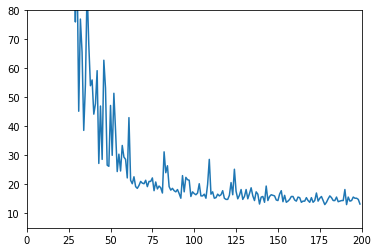

In [15]:
def softmax_policy_action_mask(state, W):
    logits = np.dot(state['state'], W)
    logits *= state['action_mask']
    softmax = np.exp(logits) / sum(np.exp(logits))
    action = np.random.choice(4, p=softmax)
    return action, softmax

num_trails = 5
num_episodes = 200
trails = []
for i in range(num_trails):
    maze_env = one_hot_maze_action_mask('hard')
    solver = PolicyGradientActorCriticSolver(maze_env, softmax_policy_action_mask)
    trails.append(solver.solve(num_episodes))

plt.axis([0, num_episodes, 5, 80])
plt.plot(np.array(trails).mean(axis=0))

C:\Users\Adam\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-12-0df3d24cb3b3>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  states = np.array(states); actions = np.array(actions); derivatives = np.array(derivatives)


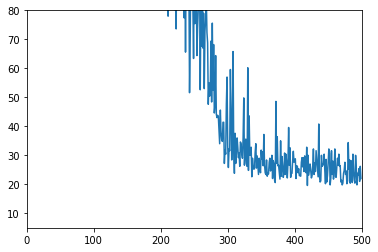

In [16]:
num_trails = 5
num_episodes = 500
trails = []
for i in range(num_trails):
    maze_env = one_hot_maze('very hard')
    solver = PolicyGradientActorCriticSolver(maze_env, softmax_policy)
    solver.lr = .05
    solver.gamma = .97
    trails.append(solver.solve(num_episodes))

plt.axis([0, num_episodes, 5, 80])
plt.plot(np.array(trails).mean(axis=0))

C:\Users\Adam\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-12-0df3d24cb3b3>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  states = np.array(states); actions = np.array(actions); derivatives = np.array(derivatives)


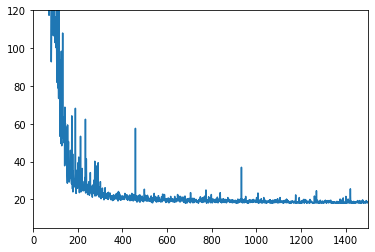

In [17]:
num_trails = 5
num_episodes = 1500
trails = []
for i in range(num_trails):
    maze_env = one_hot_maze_action_mask('very hard')
    solver = PolicyGradientActorCriticSolver(maze_env, softmax_policy_action_mask)
    solver.lr = .05
    solver.gamma = .97
    trails.append(solver.solve(num_episodes))

plt.axis([0, num_episodes, 5, 120])
plt.plot(np.array(trails).mean(axis=0))

In [ ]:
evaluation

C:\Users\Adam\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'evaluation' is not defined

In [ ]:
def softmax_policy_action_mask_eval(state, W):
    logits = np.dot(state['state'], W)
    logits *= state['action_mask']
    softmax = np.exp(logits) / sum(np.exp(logits))
    action = np.argmax(softmax)
    return action, None

state = solver.env.reset()
solver.policy = softmax_policy_action_mask_eval
total_reward = 0
while not solver.env.done:
    action, probs = solver.policy(state, solver.W)
    new_state, reward, done, _, _ = solver.env.step(action)
    state = new_state
    total_reward += reward

print(solver.env.steps)
print(total_reward)

18
8.299999999999999


C:\Users\Adam\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
